In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [3]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [4]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [5]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
print('Loaded RT data')

# Aggregating settlement location for system-wide data
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

Loaded RT data


,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [6]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
print('Loaded DA data')

# Aggregating settlement location for system-wide data
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.head()

Loaded DA data


,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 01:00:00,01/01/2018 01:00:00,37.390157,2018-01-01,01:00:00,01:00:00,True,1,1,60
01/01/2018 02:00:00,01/01/2018 02:00:00,37.249877,2018-01-01,02:00:00,02:00:00,True,1,1,120
01/01/2018 03:00:00,01/01/2018 03:00:00,37.998882,2018-01-01,03:00:00,03:00:00,True,1,1,180
01/01/2018 04:00:00,01/01/2018 04:00:00,40.778408,2018-01-01,04:00:00,04:00:00,True,1,1,240
01/01/2018 05:00:00,01/01/2018 05:00:00,42.051515,2018-01-01,05:00:00,05:00:00,True,1,1,300


In [42]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d
def means_std_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = [round(np.array(d[key]).mean(),6),round(stats.sem(np.array(d[key])),6)]
    return means_d

In [8]:
# Merging RT, DA and Load data
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time'})

In [9]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

In [10]:
# Adding RT moving average

step = 3
previous_RT = DART_gen_2018['LMP_RT'].iloc[0:(DART_gen_2018.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
for i in range(DART_gen_2018.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
DART2018 = DART_gen_2018.iloc[step:,:]
DART2018['Previous_RT_2'] = previous_means_RT

DART2018.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,Nuclear Market,...,Interval_RT,LMP_RT,Local Date_price,Local Time,Hour,Weekday,Month,Day,Minute of Day,Previous_RT_2
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 00:20:00,2018-01-01T06:20:00Z,2911.5,18154.1,0.0,0.0,43.3,713.7,6182.6,3438.3,0.0,...,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20,158.705908
01/01/2018 00:25:00,2018-01-01T06:25:00Z,2895.3,18181.1,0.0,0.0,43.3,678.1,6184.3,3467.2,0.0,...,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25,134.472676
01/01/2018 00:30:00,2018-01-01T06:30:00Z,2896.4,18189.0,0.0,0.0,43.7,678.2,6183.5,3459.6,0.0,...,01/01/2018 00:30:00,126.647321,2018-01-01,00:30:00,00:00:00,True,1,1,30,167.302321
01/01/2018 00:35:00,2018-01-01T06:35:00Z,2894.9,18226.5,0.0,0.0,43.2,678.1,6189.4,3415.3,0.0,...,01/01/2018 00:35:00,125.841131,2018-01-01,00:35:00,00:00:00,True,1,1,35,154.622745
01/01/2018 00:40:00,2018-01-01T06:40:00Z,2883.9,18149.6,0.0,0.0,43.4,533.8,6433.6,3385.3,0.0,...,01/01/2018 00:40:00,97.449310,2018-01-01,00:40:00,00:00:00,True,1,1,40,138.613818


In [14]:
# 2017 data

SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'
RT_path = '\\RT\\2017\\LMP_SL_2017.csv'
DA_path = '\\DA\\2017\\LMP_SL_2017.csv'
RT_2017 = pd.read_csv(SPP_path + RT_path)
print('Loaded RT data')
DA_2017 = pd.read_csv(SPP_path + DA_path)
print('Loaded DA data')

Loaded RT data
Loaded DA data


In [15]:
# Aggregating data

RT2017_aggloc = RT_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                      'LMP':'mean'})
RT2017_aggloc = add_info(RT2017_aggloc)


DA2017_aggloc = DA_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                    'LMP':'mean'})
DA2017_aggloc = add_info(DA2017_aggloc)
DA2017_aggloc.head()

,INTERVAL,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
INTERVAL,,,,,,,,,
2017-01-01 01:00:00.000000,2017-01-01 01:00:00.000000,21.983863,2017-01-01,01:00:00,01:00:00,False,1,1,60
2017-01-01 02:00:00.000000,2017-01-01 02:00:00.000000,20.761607,2017-01-01,02:00:00,02:00:00,False,1,1,120
2017-01-01 03:00:00.000000,2017-01-01 03:00:00.000000,19.944763,2017-01-01,03:00:00,03:00:00,False,1,1,180
2017-01-01 04:00:00.000000,2017-01-01 04:00:00.000000,20.188906,2017-01-01,04:00:00,04:00:00,False,1,1,240
2017-01-01 05:00:00.000000,2017-01-01 05:00:00.000000,20.363023,2017-01-01,05:00:00,05:00:00,False,1,1,300


In [16]:
gen_mix_2017 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')
list_intervals = gen_mix_2017[gen_mix_2017.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2017['Local Date'] = np.array(local_date)
gen_mix_2017['Local Time'] = np.array(local_time)
gen_mix_2017.head()

,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,Wind,Waste Heat,Other,Average Actual Load,Local Date,Local Time
0,2017-01-01T06:00:00Z,2956.2,13385.3,0.0,251.8,3025.9,2098.4,0.0,7.7,4499.1,0.0,35.4,25380.548,2017-01-01,00:00:00
1,2017-01-01T06:05:00Z,2920.2,13342.3,0.0,241.7,2988.6,2100.8,0.0,8.1,4529.3,0.0,35.7,25356.102,2017-01-01,00:05:00
2,2017-01-01T06:10:00Z,2920.2,13254.2,0.0,241.7,2969.2,2100.8,0.0,8.1,4529.3,0.0,35.7,25356.102,2017-01-01,00:10:00
3,2017-01-01T06:15:00Z,2923.2,13380.3,0.0,267.6,2981.2,2099.1,0.0,8.1,4551.8,0.0,35.7,25358.945,2017-01-01,00:15:00
4,2017-01-01T06:20:00Z,2900.3,13388.1,0.0,276.7,2960.1,2099.8,0.0,8.7,4603.1,0.0,36.4,25345.252,2017-01-01,00:20:00


In [17]:
# Merging RT, DA and Load data
comparison = DA2017_aggloc.iloc[:,1:2].join(RT2017_aggloc,how='right',lsuffix='_DA',rsuffix='_RT')
DART2017_5min = filler(comparison, 'LMP_DA')
new_index = []
for i in range(DART2017_5min.shape[0]):
    new_index.append(DART2017_5min['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + DART2017_5min['Local Time'].iloc[i].strftime("%H:%M:%S"))
DART2017_5min.index = np.array(new_index)
DART2017_5min.head()

,LMP_DA,INTERVAL,LMP_RT,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
01/01/2017 00:05:00,0.0,2017-01-01 00:05:00.000000,16.911322,2017-01-01,00:05:00,00:00:00,False,1,1,5
01/01/2017 00:10:00,0.0,2017-01-01 00:10:00.000000,17.264418,2017-01-01,00:10:00,00:00:00,False,1,1,10
01/01/2017 00:15:00,0.0,2017-01-01 00:15:00.000000,16.422609,2017-01-01,00:15:00,00:00:00,False,1,1,15
01/01/2017 00:20:00,0.0,2017-01-01 00:20:00.000000,21.653247,2017-01-01,00:20:00,00:00:00,False,1,1,20
01/01/2017 00:25:00,0.0,2017-01-01 00:25:00.000000,18.293177,2017-01-01,00:25:00,00:00:00,False,1,1,25


In [28]:
gen_2017 = gen_mix_2017
new_index = []
for i in range(gen_2017.shape[0]):
    new_index.append(gen_2017['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2017['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2017.index = np.array(new_index)
DART_gen_2017 = gen_2017.join(DART2017_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2017 = DART_gen_2017.rename(columns={' Average Actual Load':'Load',
                                             ' Wind':'Wind',
                                             'Local Time_price':'Local Time'})
DART_gen_2017.tail()

,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,Wind,...,LMP_DA,INTERVAL,LMP_RT,Local Date_price,Local Time,Hour,Weekday,Month,Day,Minute of Day
12/31/2017 23:40:00,2018-01-01T05:40:00Z,2946.7,18733.8,4.4,794.6,8674.2,2034.5,0.0,11.0,3817.7,...,43.236809,2017-12-31 23:40:00.000000,33.915670,2017-12-31,23:40:00,23:00:00,False,12,31,1420
12/31/2017 23:45:00,2018-01-01T05:45:00Z,2943.9,18774.4,4.4,734.3,8678.3,2034.4,0.0,11.0,3730.8,...,43.236809,2017-12-31 23:45:00.000000,31.556102,2017-12-31,23:45:00,23:00:00,False,12,31,1425
12/31/2017 23:50:00,2018-01-01T05:50:00Z,2946.8,18795.1,4.4,733.4,8692.2,2033.3,0.0,10.9,3709.5,...,43.236809,2017-12-31 23:50:00.000000,33.072190,2017-12-31,23:50:00,23:00:00,False,12,31,1430
12/31/2017 23:55:00,2018-01-01T05:55:00Z,2952.1,18232.8,4.4,798.0,9186.7,2034.4,0.0,10.8,3718.2,...,43.236809,2017-12-31 23:55:00.000000,33.519099,2017-12-31,23:55:00,23:00:00,False,12,31,1435
01/01/2018 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.699045,2018-01-01 00:00:00.000000,251.014564,2018-01-01,00:00:00,00:00:00,True,1,1,0


In [29]:
# Adding RT moving average

step = 3
previous_RT = DART_gen_2017['LMP_RT'].iloc[0:(DART_gen_2017.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
for i in range(DART_gen_2017.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
DART2017 = DART_gen_2017.iloc[step:,:]
DART2017['Previous_RT_2'] = previous_means_RT

DART2017.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,GMT MKT Interval,Coal Market,Coal Self,Diesel Fuel Oil,Hydro,Natural Gas,Nuclear,Solar,Waste Disposal Services,Wind,...,INTERVAL,LMP_RT,Local Date_price,Local Time,Hour,Weekday,Month,Day,Minute of Day,Previous_RT_2
01/01/2017 00:20:00,2017-01-01T06:20:00Z,2900.3,13388.1,0.0,276.7,2960.1,2099.8,0.0,8.7,4603.1,...,2017-01-01 00:20:00.000000,21.653247,2017-01-01,00:20:00,00:00:00,False,1,1,20,16.866116
01/01/2017 00:25:00,2017-01-01T06:25:00Z,2878.0,13387.8,0.0,276.7,2915.2,2099.1,0.0,9.4,4670.5,...,2017-01-01 00:25:00.000000,18.293177,2017-01-01,00:25:00,00:00:00,False,1,1,25,18.446758
01/01/2017 00:30:00,2017-01-01T06:30:00Z,2858.1,13294.4,0.0,276.9,2972.1,2098.9,0.0,10.2,4766.9,...,2017-01-01 00:30:00.000000,18.362924,2017-01-01,00:30:00,00:00:00,False,1,1,30,18.789678
01/01/2017 00:35:00,2017-01-01T06:35:00Z,2819.1,13243.0,0.0,276.7,2921.3,2098.9,0.0,10.0,4913.4,...,2017-01-01 00:35:00.000000,18.071030,2017-01-01,00:35:00,00:00:00,False,1,1,35,19.436450
01/01/2017 00:40:00,2017-01-01T06:40:00Z,2774.3,13129.6,0.0,277.3,2889.4,2101.3,0.0,10.4,5033.2,...,2017-01-01 00:40:00.000000,17.731023,2017-01-01,00:40:00,00:00:00,False,1,1,40,18.242377


In [30]:
DART = pd.concat([DART2017, DART2018])

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
# Calculating avg slopes

np.seterr(divide='print',invalid='print')

n = 10
PE_8_list = []
errors = 0

df = DART2018

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (8)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
                for var in result8.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result8.params.loc[var])
                    else:
                        slopes[var].append(result8.params.loc[var])
                for hour in cluster.index:
                    test_data_copy['fitted RT (8)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[6] +  
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_8_list.append(pe(test_data_copy['fitted RT (8)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_8_array = np.array(PE_8_list)

print('\nMAPE \u00B1 std')
print('6 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('# of errors: {}'.format(errors))

100.0%
MAPE ± std
6 predictors: 7.601989313658685 ± 2.762690015315638
# of errors: 0


In [43]:
means_std_dict(slopes)

{'Intercept': [-2.967397, 2.429615],
 'LMP_DA': [-0.073152, 0.033698],
 'RT_std': [0.126332, 0.012571],
 'DA_std': [-0.127069, 0.028163],
 'Load': [0.000905, 0.000144],
 'Wind': [-0.000906, 0.000266],
 'Previous_RT_2': [0.228136, 0.010878]}

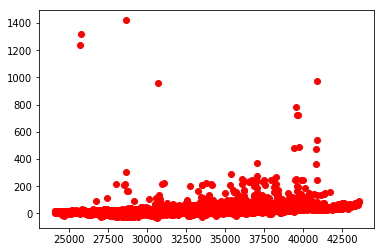

In [12]:
jan = DART2018[DART2018['Month']==1]
x = jan['Load'].values.tolist()
y = jan['LMP_RT'].values.tolist()
plt.plot(x,y,'ro')jan = DART2018[DART2018['Month']==1]
x = jan['Load'].values.tolist()
y = jan['LMP_RT'].values.tolist()
plt.plot(x,y,'ro')

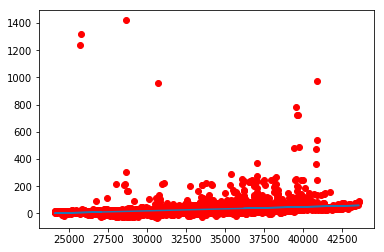

In [36]:
jan = DART2018[(DART2018['Month']==1)]
x = jan['Load']
y = jan['LMP_RT']
k = 0
x1 = []
y1 = []
for value in x:
    if np.isnan(value) == False:
        x1.append(x[k])
        y1.append(y[k])
    k += 1
x1 = np.array(x1)
y1 = np.array(y1)
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1,y1,'ro')
plt.plot(x1,x1*m+b)

In [44]:
m

0.0029293927327733453

In [41]:
result = smf.ols(formula="""LMP_RT ~ Load""", data=DART2018).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2451.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:51:09   Log-Likelihood:            -5.3478e+05
No. Observations:              104858   AIC:                         1.070e+06
Df Residuals:                  104856   BIC:                         1.070e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.6970      0.699    -13.869      0.000     -11.067      -8.327
Load           0.0011   2.22e-05     49.507      0.000       0.001       0.001
==============================================================================
Omnibus:                   225917.332   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1292904342.091
Skew:                          19.349   Prob(JB):                         0.00
Kurtosis:                     545.608   Cond. No.                     1.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
result = smf.ols(formula="""LMP_RT ~ I(Load)**2""", data=DART2018).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2451.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:02:53   Log-Likelihood:            -5.3478e+05
No. Observations:              104858   AIC:                         1.070e+06
Df Residuals:                  104856   BIC:                         1.070e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.6970      0.699    -13.869      0.000     -11.067      -8.327
I(Load)        0.0011   2.22e-05     49.507      0.000       0.001       0.001
==============================================================================
Omnibus:                   225917.332   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1292904342.091
Skew:                          19.349   Prob(JB):                         0.00
Kurtosis:                     545.608   Cond. No.                     1.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

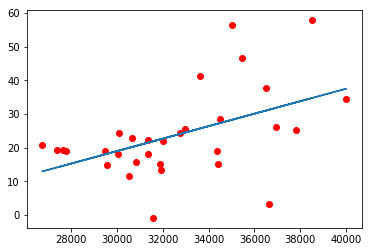

In [48]:
jan1 = jan[jan['Local Time']==dt.time(12,0)]
x1 = jan1['Load']
y1 = jan1['LMP_RT']
m, b, r, p, std = stats.linregress(x1, y1)
plt.plot(x1,y1,'ro')
plt.plot(x1,x1*m+b)
r**2

In [51]:
jan1 = jan[jan['Local Time']==dt.time(12,0)]
x1 = jan1['Load']
y1 = jan1['LMP_RT']
result = smf.ols(formula="""LMP_RT ~ I(Load)**2""", data=jan1).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     8.768
Date:                Fri, 31 Jul 2020   Prob (F-statistic):            0.00606
Time:                        13:02:10   Log-Likelihood:                -119.23
No. Observations:                  31   AIC:                             242.5
Df Residuals:                      29   BIC:                             245.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.7397     20.545     -1.788      0.084     -78.759       5.280
I(Load)        0.0019      0.001      2.961      0.006       0.001       0.003
==============================================================================
Omnibus:                        2.488   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                1.309
Skew:                           0.142   Prob(JB):                        0.520
Kurtosis:                       3.966   Cond. No.                     3.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

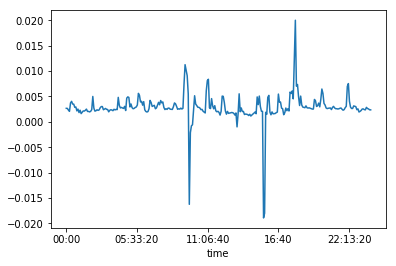

In [59]:
hours = jan.groupby('Local Time').count().index
slopes = []
for time in hours:
    result = smf.ols(formula="""LMP_RT ~ Load""", data=jan[jan['Local Time']==time]).fit()
    slopes.append(result.params.loc['Load'])
plt.plot(hours,slopes)

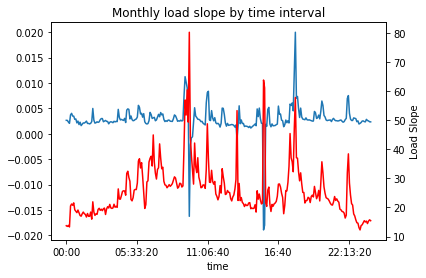

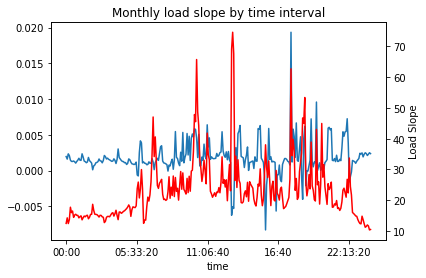

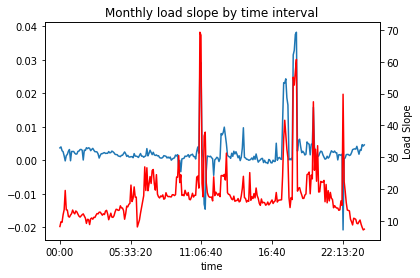

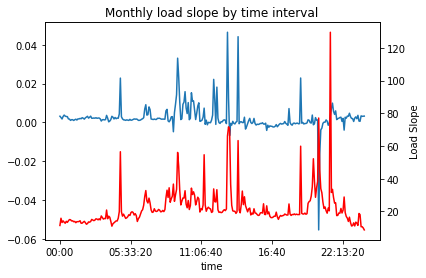

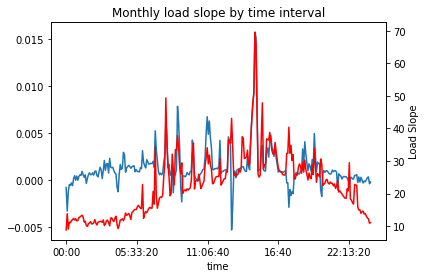

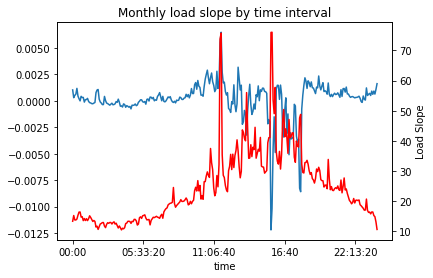

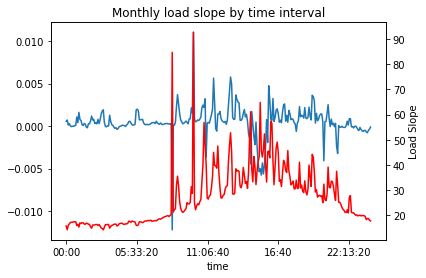

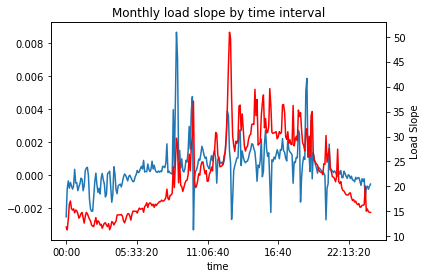

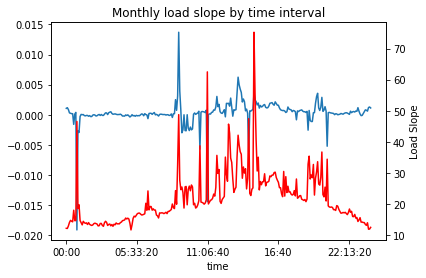

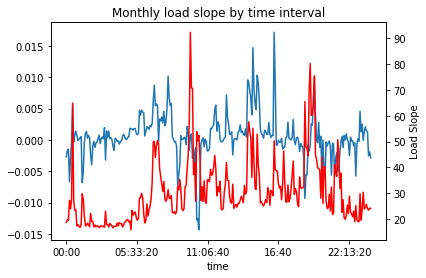

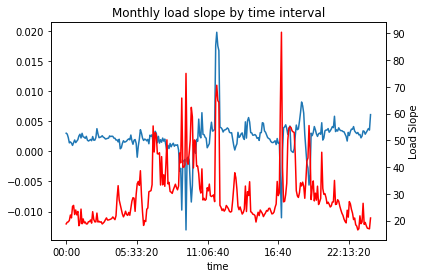

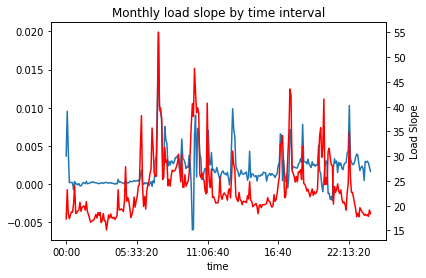

In [63]:
intervals = DART2018.groupby('Local Time').count().index
for month in range (1,13):
    month_df = DART2018[DART2018['Month']==month]
    slopes = []
    for t in intervals:
        result = smf.ols(formula = "LMP_RT ~ Load", data = month_df[month_df['Local Time']==t]).fit()
        slopes.append(result.params.loc['Load'])
    fig, ax = plt.subplots()
    ax.plot(hours, slopes)
    ax2 = ax.twinx()
    ax2.plot(hours, month_df.groupby('Local Time')[['LMP_RT']].mean()['LMP_RT'], 'red')
    plt.ylabel('Load Slope')
    plt.title('Monthly load slope by time interval')
    plt.show()
    